In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima



In [2]:
df=pd.read_csv('Erathna_project.csv')
df.head()




,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,130.2,22.1,32.1,NaN,NaN
1,2010,February,41.3,22.6,33.9,NaN,NaN
2,2010,March,171.5,23.1,35.2,NaN,NaN
3,2010,April,421.7,23.7,33.5,NaN,NaN
4,2010,May,793.3,24.0,31.8,NaN,NaN


In [3]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)


In [4]:
df.head()


,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,130.2,22.1,32.1,NaN,NaN,2010-January
1,2010,February,41.3,22.6,33.9,NaN,NaN,2010-February
2,2010,March,171.5,23.1,35.2,NaN,NaN,2010-March
3,2010,April,421.7,23.7,33.5,NaN,NaN,2010-April
4,2010,May,793.3,24.0,31.8,NaN,NaN,2010-May


In [5]:
#Slicing dataset
temperature_max=df[["Time","Temp_max"]]
temperature_max.head()


,Time,Temp_max
0,2010-January,32.1
1,2010-February,33.9
2,2010-March,35.2
3,2010-April,33.5
4,2010-May,31.8


In [6]:
temperature_max['Time']=pd.to_datetime(temperature_max['Time'])

C:\Users\wasan\AppData\Local\Temp/ipykernel_15644/653730226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_max['Time']=pd.to_datetime(temperature_max['Time'])


In [7]:
temperature_max.head()

,Time,Temp_max
0,2010-01-01,32.1
1,2010-02-01,33.9
2,2010-03-01,35.2
3,2010-04-01,33.5
4,2010-05-01,31.8


In [8]:
#Checking for missing values
temperature_max.isna().sum()


Time        0
Temp_max    1
dtype: int64

In [9]:
#Setting the time index
temperature_max.set_index('Time',inplace=True)

In [10]:
temperature_max=temperature_max.resample('MS').first()

In [11]:
#removing missing values
temp=temperature_max.fillna(method='bfill')
temp.head(20)

,Temp_max
Time,
2010-01-01,32.1
2010-02-01,33.9
2010-03-01,35.2
2010-04-01,33.5
2010-05-01,31.8
2010-06-01,30.9
2010-07-01,30.8
2010-08-01,30.3
2010-09-01,30.9


In [12]:
#Checking for missing values
temp.isna().sum()

Temp_max    0
dtype: int64

In [13]:
#Rename column
temp = temp.rename(columns = {'Temp_max': 'Temperature Max'}, inplace = False)
temp.head()

,Temperature Max
Time,
2010-01-01,32.1
2010-02-01,33.9
2010-03-01,35.2
2010-04-01,33.5
2010-05-01,31.8


In [14]:
#Checking for missing values
temp.isna().sum()

Temperature Max    0
dtype: int64

<AxesSubplot:xlabel='Time'>

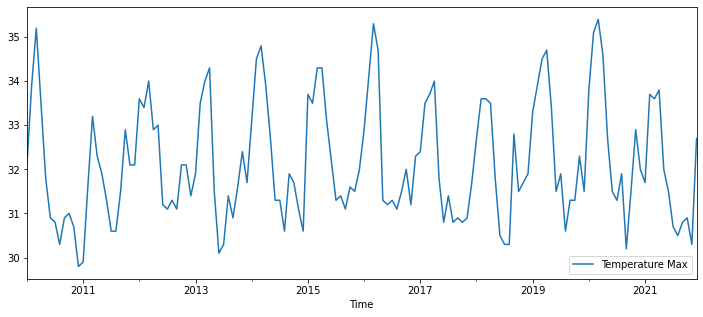

In [15]:
temp.plot(figsize=(12,5))

It can't be cleary identified trend. But there is some evidence for seasonality.

In [16]:
### ADF Test
test_result=adfuller(temp['Temperature Max'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(rainfall):
    result=adfuller(rainfall)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(temp['Temperature Max'])


ADF Test Statistic : -3.553556869903139
p-value : 0.006713576642948055
#Lags Used : 14
Number of Observations Used : 129
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [17]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(temp['Temperature Max'])


KPSS Statistic: 0.10489764886864736
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [18]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(temp['Temperature Max'].astype(float))
print(pp.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.024
P-value                         0.001
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

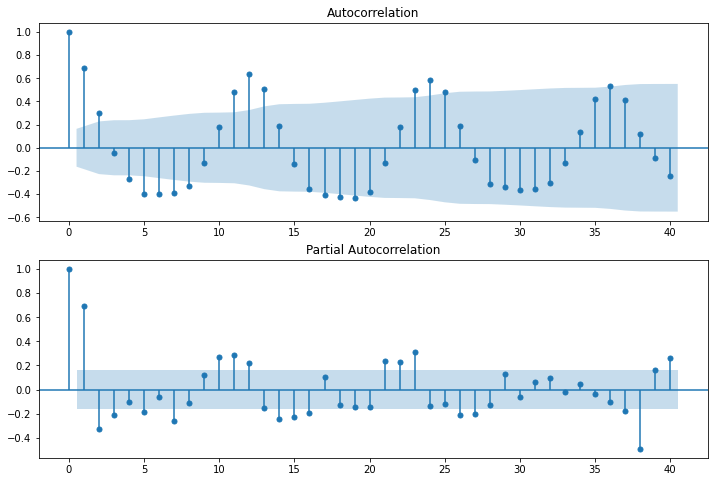

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp['Temperature Max'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp['Temperature Max'],lags=40,ax=ax2)


According to the PACF and ACF plots, series is likely to follow a MA process. Better to start with p=0,q=3, d=0

In [21]:
arima_model=auto_arima(temp['Temperature Max'].astype(float),start_q=0,max_q=3,max_p=4,start_Q=0,max_Q=3,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,information_criterion='aic',maxiter=70)


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=495.999, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=450.022, Time=0.08 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=425.889, Time=0.27 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=423.354, Time=0.70 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=408.074, Time=0.97 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=413.983, Time=1.65 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.85 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=423.806, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=393.120, Time=0.11 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=384.146, Time=0.29 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept

C:\Users\wasan\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,0,0)(1,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=346.487, Time=1.17 sec
 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=377.381, Time=1.62 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=383.843, Time=0.52 sec
 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=369.082, Time=0.95 sec
 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=16124.466, Time=1.11 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=385.518, Time=0.42 sec
 ARIMA(4,0,0)(0,0,0)[12] intercept   : AIC=387.925, Time=0.23 sec
 ARIMA(4,0,0)(0,0,1)[12] intercept   : AIC=372.293, Time=0.52 sec
 ARIMA(4,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=385.899, Time=0.61 sec

Best model:  ARIMA(1,0,0)(1,0,1)[12] intercept
Total fit time: 116.234 seconds


In [20]:
model=sm.tsa.statespace.SARIMAX(temp['Temperature Max'].astype('float'),order=(2, 0, 0),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Temperature Max   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -179.727
Date:                              Tue, 26 Apr 2022   AIC                            369.454
Time:                                      01:42:31   BIC                            384.303
Sample:                                  01-01-2010   HQIC                           375.488
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6776      0.050     13.567      0.000       0.580       0.775
ar.L2          0.3219      0.050      6.429      0.000       0.224       0.420
ar.S.L12       0.9993      0.004    238.720      0.000       0.991       1.007
ma.S.L12      -0.9547      0.121     -7.881      0.000      -1.192      -0.717
sigma2         0.5356      0.064      8.305      0.000       0.409       0.662
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):                11.10
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.32
Prob(H) (two-sided):                  0.47   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
beg_dt='2014-01-01'
end_dt='2025-12-01'

In [ ]:
#results.predict(start=beg_dt,end=end_dt,dynamic=True)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

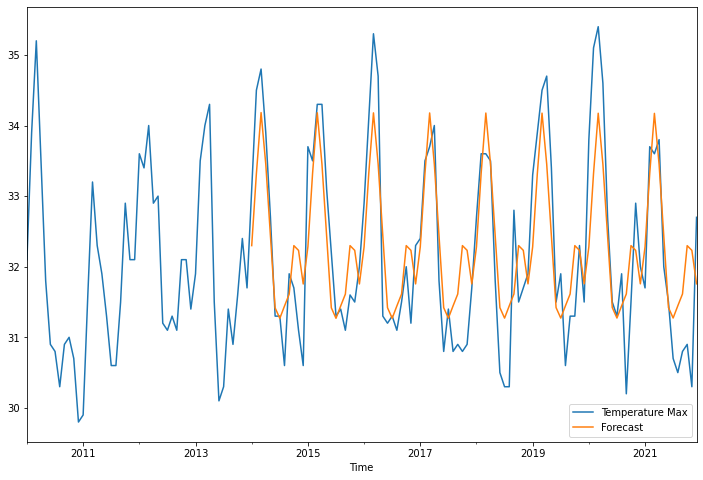

In [28]:
temp['Forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
temp[['Temperature Max','Forecast']].plot(figsize=(12,8))


In [24]:
temp.tail()




,Temperature Max,Forecast
Time,,
2021-08-01,30.5,30.524530
2021-09-01,30.8,30.810334
2021-10-01,30.9,31.329956
2021-11-01,30.3,NaN
2021-12-01,32.7,NaN
